In [21]:
from utils import *
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy
import numpy as np
import cupy as cp
import math
import json
from PIL import Image, ImageDraw

In [78]:
config = Config()
IMAGE_SIZE = config.sample_size

device_marker = np.empty(1)
xp = cp.get_array_module(device_marker)

RNG = xp.random.default_rng()

In [23]:
%%time
IMAGES = []
IMAGES_METADATA = []

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name)) as f:
    metadata = json.load(f)

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.width == IMAGE_SIZE
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        metadata_record = metadata[os.path.basename(image_fname)]
        metadata_record = np.rec.array([(image_fname, metadata_record.get('value', '?'))], dtype=[('file_name', 'object'), ('value', 'object')])
        IMAGES_METADATA.append(metadata_record)
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGES_METADATA)
IMAGES = np.array(IMAGES)
IMAGES_METADATA = np.rec.array(np.concatenate(IMAGES_METADATA))
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/10001 [00:00<?, ?it/s]

Loaded 10000 images
CPU times: user 1.32 s, sys: 89.9 ms, total: 1.41 s
Wall time: 1.41 s


In [24]:
def matrix_to_image(m):
    return Image.frombytes('L', size=(IMAGE_SIZE, IMAGE_SIZE), data=m.reshape(IMAGE_SIZE, IMAGE_SIZE).astype(xp.uint8))

In [25]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
SENSOR_GROUP_SIZE = 4
SENSOR_GROUP_SQUARE = SENSOR_GROUP_SIZE * SENSOR_GROUP_SIZE
RETINA_SIZE = 16
RETINA_SQUARE = RETINA_SIZE * RETINA_SIZE


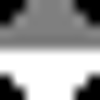
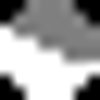
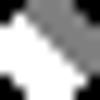
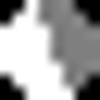
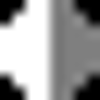
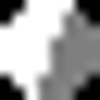
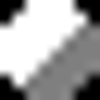
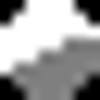
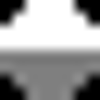
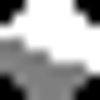
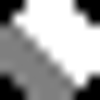
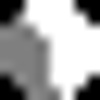
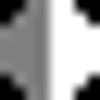
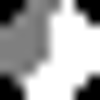
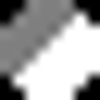
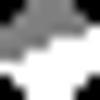

In [26]:
group_sensors_img = []
captions = []
steps = pow(SENSOR_GROUP_SIZE, 2)
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    draw.ellipse([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], outline=0, fill=127, width=0)
    angle = i * 360 / steps
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    group_sensors_img.append(canvas)
    captions.append(f'#{i} ({i // SENSOR_GROUP_SIZE}, {i % SENSOR_GROUP_SIZE})')

display_images_grid(list(map(lambda x: x.crop([0,0,SENSOR_RECEPTIVE_FIELD_SIZE,SENSOR_RECEPTIVE_FIELD_SIZE]).resize((100, 100)), group_sensors_img)), col_count=SENSOR_GROUP_SIZE, captions=captions)

In [27]:
group_sensors = xp.array(list(map(xp.array, group_sensors_img))).astype(float)
shape_save = group_sensors.shape
group_sensors = group_sensors.reshape(SENSOR_GROUP_SIZE*SENSOR_GROUP_SIZE, -1)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
group_sensors[group_sensors==255] = 1
counts_of_positives = (group_sensors == 1).sum(axis=1)
counts_of_negatives = (group_sensors == 127).sum(axis=1)
white_image = xp.ones(group_sensors.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    group_sensors[i][group_sensors[i] == 127] = -1 * (p / n)
    v = group_sensors[i] @ white_image
    assert xp.isclose(v, 0), v

group_sensors = group_sensors.reshape(shape_save)
group_sensors.shape, np.unique_counts(group_sensors)

((16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.26086957, -1.16666667, -1.08      , -1.        ,
         0.        ,  1.        ]), counts=array([    44,    138,     48,     50,    104, 261312,    448])))

In [28]:
group_sensors_ones = (group_sensors.reshape(group_sensors.shape[0], -1) == 1).sum(axis=1)
group_sensors_ones, group_sensors_ones.mean(), group_sensors_ones.min(), group_sensors_ones.max(), group_sensors_ones.std()

(array([26, 27, 29, 28, 26, 28, 29, 27, 26, 29, 29, 30, 26, 30, 29, 29]),
 np.float64(28.0),
 np.int64(26),
 np.int64(30),
 np.float64(1.4142135623730951))


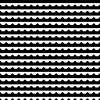
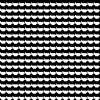
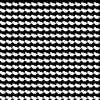
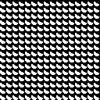
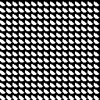
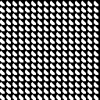
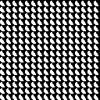
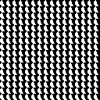
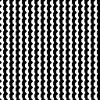
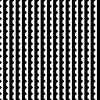
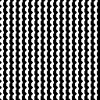
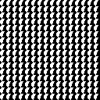
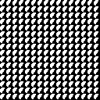
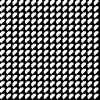
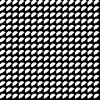
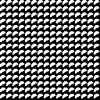
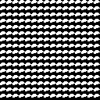
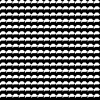
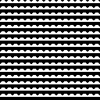
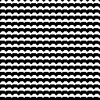
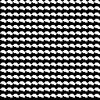
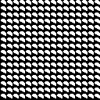
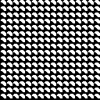
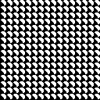
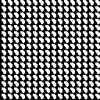
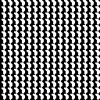
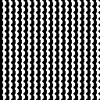
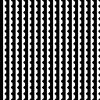
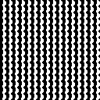
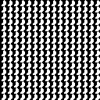
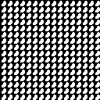
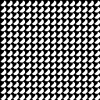
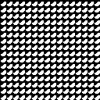
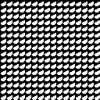
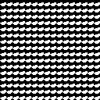
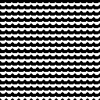

In [29]:
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
steps = 36 # 10 degreee
specific_samples_img = []
captions = []

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    angle = i * 360 / steps
       
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    crop = canvas.crop([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE])

    for x in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
        for y in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
            canvas.paste(crop, [x, y, x + SENSOR_RECEPTIVE_FIELD_SIZE, y + SENSOR_RECEPTIVE_FIELD_SIZE])
            
    specific_samples_img.append(canvas)
    captions.append(f'#{i}')

display_images_grid(list(map(lambda x: x.resize((100, 100)), specific_samples_img)), col_count=int(np.sqrt(steps)), captions=captions)

In [30]:
SPECIFIC_SAMPLES = xp.array(list(map(xp.array, specific_samples_img))).astype(float)
SPECIFIC_SAMPLES[SPECIFIC_SAMPLES==255] = 1
SPECIFIC_SAMPLES = SPECIFIC_SAMPLES.reshape(SPECIFIC_SAMPLES.shape[0], -1)
SPECIFIC_SAMPLES.shape, np.unique_counts(SPECIFIC_SAMPLES)

((36, 16384),
 UniqueCountsResult(values=array([0., 1.]), counts=array([331776, 258048])))

In [31]:
# single sensor occupies (RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE) ^ 2
# we have group of such sensors stacked under each other in a square fashion, hence SENSOR_GROUP_SIZE^2
# to cover all visual area we have RETINA_SIZE^2 of such groups
retina = xp.zeros((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
retina = retina.reshape((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1))

for y in range(RETINA_SIZE):
    for x in range(RETINA_SIZE):
        for g in range(pow(SENSOR_GROUP_SIZE, 2)):
            sensor_at_place = group_sensors[g]
            sensor_at_place = np.roll(sensor_at_place, y * SENSOR_RECEPTIVE_FIELD_SIZE, axis=0)
            sensor_at_place = np.roll(sensor_at_place, x * SENSOR_RECEPTIVE_FIELD_SIZE, axis=1)
            retina[y, x, g, :] = sensor_at_place.reshape(-1)

retina = retina.reshape((-1, pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
RETINA_POS = retina
RETINA_NEG = retina.copy()

RETINA_POS[RETINA_POS < 0] = 0
RETINA_NEG[RETINA_NEG > 0] = 0

In [32]:
assert xp.array_equal(xp.unique(SPECIFIC_SAMPLES), [0, 1])

specific_samples_sense_pos = RETINA_POS @ SPECIFIC_SAMPLES.T
specific_samples_sense_neg = RETINA_NEG @ SPECIFIC_SAMPLES.T
specific_samples_sense_pos = specific_samples_sense_pos.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_neg = specific_samples_sense_neg.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_ref = specific_samples_sense_pos.copy() # reference
assert specific_samples_sense_pos.shape == specific_samples_sense_neg.shape

# Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
# Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
# Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
# For specific samples situation is more straighforward, since is liminiscense is binary (0 or 1)
for y in range(specific_samples_sense_ref.shape[0]):
    for x in range(specific_samples_sense_ref.shape[1]):
        # Matrix of how each group of sensors (rows) perceives each of specific samples (columns)
        perceive_matrix = specific_samples_sense_ref[y, x]
        assert perceive_matrix.shape == (pow(SENSOR_GROUP_SIZE, 2), SPECIFIC_SAMPLES.shape[0])
        cond1 = (perceive_matrix.T / group_sensors_ones).T >= 0.5 # At least half of a positive area of each of sensors is activated

        perceive_matrix_pos = specific_samples_sense_pos[y, x]
        perceive_matrix_neg = xp.abs(specific_samples_sense_neg[y, x])
        assert perceive_matrix_pos.shape == perceive_matrix.shape
        assert perceive_matrix_neg.shape == perceive_matrix.shape

        cond2 = perceive_matrix_pos > perceive_matrix_neg # There is more activation on positive areas than on negative
        assert cond1.shape == cond2.shape
        specific_samples_sense_ref[y, x] = (cond1 & cond2).astype(float)

for i in range(SPECIFIC_SAMPLES.shape[0]):
    v = specific_samples_sense_ref[0, 0, :, i]
    print(f'{v} => {(v == 1).sum()}')

    for y in range(specific_samples_sense_ref.shape[0]):
        for x in range(specific_samples_sense_ref.shape[1]):
            assert xp.array_equal(v, specific_samples_sense_ref[y, x, :, i])

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 7
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 7
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 

In [33]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image

In [39]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images(images, active_sensors=None):
    active_sensors = xp.ones((RETINA_SQUARE * SENSOR_GROUP_SQUARE, 1)) if active_sensors is None else active_sensors
    assert active_sensors.shape == (RETINA_POS.shape[0], 1)
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    effective_retina_pos = RETINA_POS * active_sensors
    effective_retina_neg = RETINA_NEG * active_sensors
    sense_area = (effective_retina_pos @ image_masks.T).T # for check of illuminated area
    sense_level = (effective_retina_pos @ images.T).T # for check of absolute illumination
    sense_neg_level = (effective_retina_neg @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), RETINA_SQUARE * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        sense_area_i = sense_area_i.reshape(-1, 16)
        cond1 = (sense_area_i / group_sensors_ones) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)
    
        sense_level_i = sense_level_i.reshape(-1, 16)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * group_sensors_ones) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)
    
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(float) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)


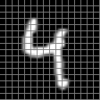
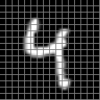
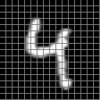
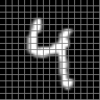
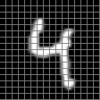
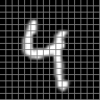
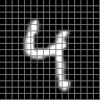
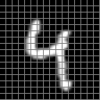
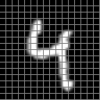
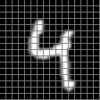
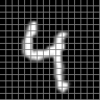
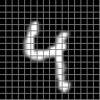
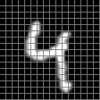
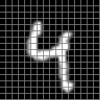
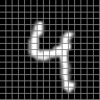
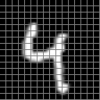
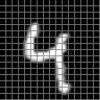
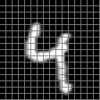
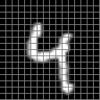
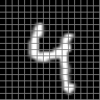
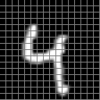
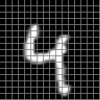
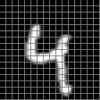
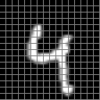
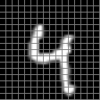
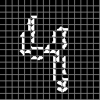
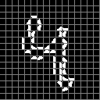
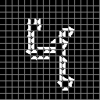
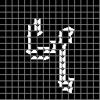
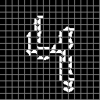
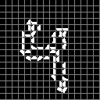
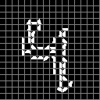
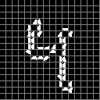
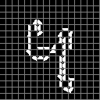
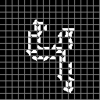
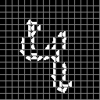
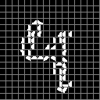
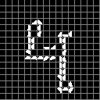
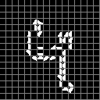
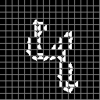
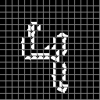
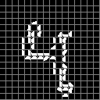
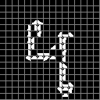
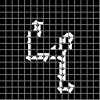
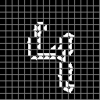
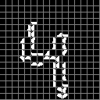
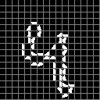
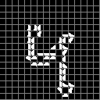
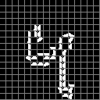
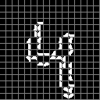

In [53]:
image_index = 10
image = IMAGES[image_index]
images = []
drifts = []
drift_range = range(-4, 6, 2)

for i in drift_range:
    for j in drift_range:
        drifts.append((i,j))

for drift in drifts:
    image_drifted = image.reshape(IMAGE_SIZE, IMAGE_SIZE)
    image_drifted = np.roll(image_drifted, drift[0], axis=0)
    rows_to_wipeout = [min(drift[0], 0) + i for i in range(abs(drift[0]))]
    image_drifted[rows_to_wipeout,:] = 0
    image_drifted = np.roll(image_drifted, drift[1], axis=1)
    cols_to_wipeout = [min(drift[1], 0) + i for i in range(abs(drift[1]))]
    image_drifted[:,cols_to_wipeout] = 0
    image_drifted = image_drifted.reshape(-1)
    images.append(image_drifted)

sensor_activationss = sense_images(np.array(images))
sensor_maps = []

for sensor_activations in sensor_activationss:
    sensor_activations = sensor_activations.reshape(RETINA_SIZE, RETINA_SIZE, SENSOR_GROUP_SQUARE)
    sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
    sensor_map = xp.zeros((sz, sz))

    for y in range(RETINA_SIZE):
        for x in range(RETINA_SIZE):
            sensors_in_group = sensor_activations[y, x]
            assert sensors_in_group.shape == (SENSOR_GROUP_SQUARE,)

            if xp.any(sensors_in_group > 0):
                # Find most similar reaction among specific samples of reactions
                a = sensors_in_group
                b = specific_samples_sense_ref[y, x, :]
                sense_vector_cos_sim = (a @ b)/(xp.linalg.norm(a) * xp.linalg.norm(b, axis=0))
                best_i = xp.argmax(sense_vector_cos_sim)
                most_similar_specific_sample = SPECIFIC_SAMPLES[best_i].reshape((sz, sz))
                srfs = SENSOR_RECEPTIVE_FIELD_SIZE
                xp.copyto(sensor_map[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs], most_similar_specific_sample[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs])

    sensor_maps.append(sensor_map * 255)

images_to_display = images + sensor_maps
images_to_display = map(lambda x: matrix_to_image(x), images_to_display)
images_to_display = map(lambda x: lay_grid(x, SENSOR_RECEPTIVE_FIELD_SIZE), images_to_display)
images_to_display = map(lambda x: x.resize((100, 100)), images_to_display)
display_images_grid(list(images_to_display), col_count=len(images))

In [185]:
N = 10_000

In [186]:
def hdv(n=1):
    size = N if n==1 else (n, N)
    return RNG.choice(np.array([-1, +1], dtype=int), size=size)

In [311]:
def absdist(hdv1, hdv2):
    assert hdv1.shape == (N,)
    assert hdv2.shape == (N,)    
    return xp.count_nonzero(hdv1 != hdv2)

In [312]:
def reldist(hdv1, hdv2):
    assert hdv1.shape == (N,)
    assert hdv2.shape == (N,)    
    return xp.count_nonzero(hdv1 != hdv2) / N

In [368]:
def bundle_ties(hdv1, *hdvs):
    if type(hdv1) is list: # bundle([x1, x2])
        assert not hdvs
        hdvs = hdv1
    else:
        match hdv1.shape:
            case (_, N): # bundle(matrix_of_hdvs)
                hdvs = hdv1
            case (N,): # bundle(x1, x2, x3)
                assert len(hdvs) > 0
                t = hdvs
                hdvs = [hdv1]
                hdvs.extend(t)
            case _:
                assert False, hdv1.shape

    sum = xp.sum(hdvs, axis=0)
    
    if len(hdvs) % 2 == 0:
        tie_breaker = hdv()
        sum = xp.sum([sum, tie_breaker], axis=0)
        
    return xp.sign(sum)

In [366]:
def bundle_noties(hdv1, *hdvs):
    if type(hdv1) is list: # bundle([x1, x2])
        assert not hdvs
        hdvs = hdv1
    else:
        match hdv1.shape:
            case (_, N): # bundle(matrix_of_hdvs)
                hdvs = hdv1
            case (N,): # bundle(x1, x2, x3)
                assert len(hdvs) > 0
                t = hdvs
                hdvs = [hdv1]
                hdvs.extend(t)
            case _:
                assert False, hdv1.shape

    sum = xp.sum(hdvs, axis=0)
    return xp.sign(sum)

In [318]:
def bind(hdv1, hdv2):
    assert hdv1.shape == (N,)
    assert hdv2.shape == (N,)
    return xp.prod([hdv1, hdv2], axis=0)    

In [237]:
def shift(hdv, k=1):
    assert hdv.shape == (N,)
    return xp.roll(hdv, k)

In [242]:
def sim(hdv1, hdv2):
    assert hdv1.shape == (N,)
    assert hdv2.shape == (N,)
    return hdv1 @ hdv2 / (xp.linalg.norm(hdv1) *  xp.linalg.norm(hdv2))

In [345]:
x1 = hdv()
x2 = hdv()
(x1 == x2).sum(), absdist(x1, x2), reldist(x1, x2), sim(x1, x2)

(np.int64(4898), 5102, 0.5102, np.float64(-0.0204))

In [376]:
b = bundle_noties(x1, x2)
x1, x2, b, absdist(x1, b), absdist(x2, b), reldist(x1, b), reldist(x2, b), sim(x1, b), sim(x2, b)

(array([-1, -1, -1, ..., -1,  1,  1]),
 array([ 1, -1,  1, ...,  1, -1,  1]),
 array([ 0, -1,  0, ...,  0,  0,  1]),
 5102,
 5102,
 0.5102,
 0.5102,
 np.float64(0.6998571282769077),
 np.float64(0.6998571282769077))

In [373]:
sim(x1, bundle_noties(x1, x2))

np.float64(0.6998571282769077)

In [351]:
b = bind(x1, x2)
x1, x2, b, reldist(x1, b), reldist(x2, b), reldist(x1, x2), sim(x1, b), sim(x2, b)

(array([-1, -1, -1, ..., -1,  1,  1]),
 array([ 1, -1,  1, ...,  1, -1,  1]),
 array([-1,  1, -1, ..., -1, -1,  1]),
 0.4972,
 0.4954,
 0.5102,
 np.float64(0.0056),
 np.float64(0.0092))

In [352]:
s = shift(x1)
x1, s, absdist(x1, s), reldist(x1, s), sim(x1, s)

(array([-1, -1, -1, ..., -1,  1,  1]),
 array([ 1, -1, -1, ..., -1, -1,  1]),
 5022,
 0.5022,
 np.float64(-0.0044))

In [353]:
m = hdv(3)
m, bundle(m)

(array([[-1, -1, -1, ...,  1,  1,  1],
        [-1,  1,  1, ...,  1, -1,  1],
        [-1, -1, -1, ...,  1,  1,  1]]),
 array([-1, -1, -1, ...,  1,  1,  1]))

In [355]:
x3 = hdv()

In [367]:
np.array_equal(bind(x1, bundle_noties(x2, x3)), bundle_noties(bind(x1, x2), bind(x1, x3)))

True

In [364]:
np.isclose(sim(x1, x2), sim(bind(x1, x3), bind(x2, x3)))

np.True_

In [365]:
np.isclose(sim(x1, x2), sim(shift(x1), shift(x2)))

np.True_